## 3.6 锐化空间滤波器

锐化(sharpen)处理的目的主要是突出灰度的**过渡部分**。

> 图像模糊可以通过在空间域用像素平均法实现，处理方式类似于**积分**。
> 容易想到，图像的锐化可以通过**微分**的方式实现。

本节讨论利用微分算子来锐化图像的各种方法。从基本规律上说，微分算子的响应强度和这一点的突变程度成正比，这样图像微分就能增强边缘和其他突变（比如噪声noise），而削弱灰度变化缓慢的区域。

### 3.6.1 微分与差分

一阶微分(differential)的定义为$\frac{\partial{f}}{\partial{x}}$，离散情况用差分(difference)代替微分，近似表示为$\frac{\partial{f}}{\partial{x}}=f(x+1)-f(x)$.

二阶微分是一阶微分的微分，所以二阶微分用差分代替可以这样表示：
$$\frac{\partial^2{f}}{\partial{x}^2}=(f(x+1)-f(x))-(f(x)-f(x-1))=f(x+1)+f(x-1)-2f(x)$$

考虑一阶微分和二阶微分的性质，对于灰度缓慢过度的梯形区域，一阶微分不为零，二阶微分则非常接近0（对于缓慢过度区域不敏感）。所以二阶微分在增强细节方面要比一阶微分好得多。**这是一个适合锐化图像的理想特性**。

### 3.6.2 使用二阶微分进行图像锐化——拉普拉斯算子

这一节介绍一个最简单的二阶微分算子来进行图像锐化。

> 构造算子的最主要的思想是构造一个微分公式，然后由此公式推导一个滤波器模板。

可以证明（Rosenfeld and Kak[1982]），最简单的各向同性微分算子是拉普拉斯算子。一个二维图像函数$f(x,y)$的拉普拉斯算子(laplace operator)定义为：
$$\nabla^2f=\frac{\partial^2f}{\partial{x}^2}+\frac{\partial^2f}{\partial{y}^2}$$

由上节定义的二阶微分公式，得出两个变量的拉普拉斯离散算子是
$$\nabla^2f(x,y)=f(x+1,y)+f(x-1,y)+f(x,y+1)+f(x,y-1)-4f(x,y)$$

如果用一个模板来表示可以写作：
$$\left(
    \begin{array}{ccc}
        0 & 1 & 0 \\
        1 & -4 & 1\\
        0 & 1 & 0
    \end{array}
   \right)$$
   
可以看出这种最简单的拉普拉斯算子模板只和**上下左右四个方向的像素**有关，另外还有一种包含四个对角的八方向拉普拉斯算子，模板如下：
$$\left(
    \begin{array}{ccc}
        1 & 1 & 1 \\
        1 & -8 & 1\\
        1 & 1 & 1
    \end{array}
   \right)$$
   
> 这里要指出的是，这是拉普拉斯算子在之前定义下推得的模板，此时模板中心为负。还可以通过相反的定义推出一个中心为正，周围为负的模板。

> 符号由微分的定义决定，本质上没有什么不同，但是在某些使用中要注意。（加还是减）

L (1113, 1158)


TypeError: 'int' object is not iterable

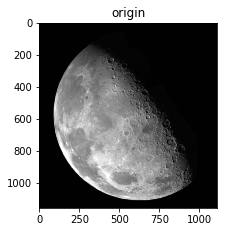

In [63]:
from PIL import Image
from filter import filter
import matplotlib.pyplot as plt
import numpy as np


img = Image.open('images/moon1.png')        # 读取图像
print(img.mode, img.size)                   # 打印图像的颜色模式和尺寸信息
img_data = np.array(img)                    # 将图像像素数据单独提取出来

plt.subplots_adjust(left=0.1, right=1.5)

plt.subplot(131)
plt.imshow(img_data, cmap='gray')           # 绘制原始图像
plt.title('origin')

# template = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])   # 定义滤波器模板

template = [-1, -1, -1, -1, 8, -1, -1, -1, -1]

img_out = filter(template, img_data)

# 滤波操作
# img_out = np.zeros(img.size, dtype='i').T
# for i in range(img.size[0]):
#     for j in range(img.size[1]):
#         try:
#             img_out[i, j] = np.sum(template * img_data[i-1:i+2, j-1:j+2])
#         except:
#             pass
# print(img_out)
plt.subplot(132)
plt.imshow(img_out, cmap='gray')            # 绘制滤波后的图像
plt.title('filted')

plt.subplot(133)
plt.imshow(img_out + img_data, cmap='gray') # 绘制锐化后的图像
plt.title('sharpened')

### 3.6.3 非锐化掩蔽（Unsharpening Mask）和高提升滤波（High Profile Information Filtering）

本小节介绍的方法在印刷和出版界被使用了很长时间，其主要方法是元图像减去一幅非锐化（平滑过的）版本。

具体由下列步骤组成：

1. 模糊原图像
2. 从原图像中减去模糊图像（产生的差值图像称为模板）
3. 将模板加到原图像上

令$\bar{f}(x,y)$表示模糊的图像，非锐化掩蔽用公式表示如下。首先我们得到模板：
$$g_{mask}(x,y)=f(x,y)-\bar{f}(x,y)$$

然后，在原图像上加上该模板的一个权重部分：
$$g(x,y)=f(x,y)+k*g_{mask}(x,y)$$

上式中的 `k` 称为权重系数。当 k = 1 时，我们得到上面定义的非锐化掩蔽。当 k > 1 时，该处理称为高提升滤波。

> k 代表了非锐化模板的贡献，k大时贡献大，反之，则小。

<img src="http://img.blog.csdn.net/20150131192302681?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvVG9ueVNoZW5nVGFu/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/Center" style="zoom:50%" />

上面的图像展示了非锐化掩蔽的原理。需要注意的是k的取值要小心，一般来说，k越大锐化效果月明显，但是k过大可能会使结果产生**负灰度**。负灰度的出现可能会使边缘出现暗晕轮。


### 3.6.4 使用一阶微分对（非线性）图像锐化——梯度

图像处理中的一阶微分是用梯度幅值来实现的。对于函数$f(x,y)$，$f$在坐标$(x,y)$处的梯度定义为二维列向量

$$\nabla f=grad(f)=\left[\begin{matrix}g_x \\ g_y\end{matrix}\right]=\left[\begin{matrix}\frac{\partial{f}}{\partial{x}} \\ \frac{\partial{f}}{\partial{y}}\end{matrix}\right]$$

> 该向量具有重要的几何特性，即指出了在位置$(x,y)$处的$f$的最大变化率的**方向**，而向量$\nabla f$的长度是梯度方向变化率在$(x,y)$处的**大小**。定义一般是$\sqrt{g_x^2+g_y^2}$，但是在实际计算中用$M(x,y)=\left|g_x\right|+\left|g_y\right|$，计算更加方便。

对于一幅图像的一个3×3区域，其中的值表示该像素的灰度值：
$$\left[\begin{matrix}z_1 & z_2 & z_3 \\z_4 & z_5 & z_6 \\z_7 & z_8 & z_9 \end{matrix}\right]$$

可以使用*Robert交叉梯度算子*：
$$\left[\begin{matrix} -1 & 0 \\ 0 & 1 \end{matrix}\right]\quad\quad和\quad\quad\left[\begin{matrix} 0 & -1 \\ 1 & 0 \end{matrix}\right]$$

偶数尺寸的模板在算法上很难实现，因为没有对称中心。在实际应用中常使用3×3的模板：
$$\left[\begin{matrix} -1 & -2 & -1\\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{matrix}\right]\quad\quad和\quad\quad\left[\begin{matrix} -1 & 0 & 1\\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{matrix}\right]$$

> **注意**：$g_x$和$g_y$的计算都是微分，属于线性操作（用差分代替，通过像素的线性组合实现），而在计算$M(x,y)$时，无论使用的是平方和开根
号还是绝对值之和，都属于非线性操作（**都是在获得$g_x$和$g_y$之后的操作**）。
